# Predicting outcome of Professional Tennis Matches with KNN Classifier

# Introduction

The Association of Tennis Professionals (ATP) is the world governing body for men’s tennis professionals and runs the ATP Tour, the top competitive circuit for men’s tennis. Within this circuit, the world’s best male tennis players compete in multiple tournaments throughout the year-long season across the Singles and Doubles disciplines for ranking points and prize money. From this large number of matches each year, involving hundreds of different players, we would like to predict the outcome of a tennis match from attributes of a player themselves, particularly height or age, or their performance during the match.

Such data is contained within the dataset https://github.com/JeffSackmann/tennis_atp, which we will use in our analysis. This dataset is a compilation of match results by year of the top 500 ATP men’s singles players from 1968 to 2021. The dataset contains information about characteristics of the players, such as their height and age, as well as various statistics of their performance within the game, such as the number of aces they hit. In our analysis, we will identify up to three predictors from this dataset that best predict match outcome. We will then use these predictors to create a classification model that predicts the outcome of a match. Given the large size of the dataset, we will confine our analysis to recent data from 2017 to 2019, and we will focus only on matches in the Singles discipline.

## Loading the Data

We begin by importing the necessary libraries and loading the tennis match data from 2017-2019 from github. The raw data has each row display a game with both the winner and loser in one row, so we mutate the data to split up each row into two parts: the winner data point and the loser data point. After mutating the data, we eliminate any potential null values and proceed to split the data into training and testing sets. 

In [1]:
# Import Libaries
library(tidyverse)
library(tidymodels)
library(repr)
library(rvest)
library(stringr)
library(cowplot)

library(tidyverse)
library(GGally)
library(ISLR)
options(repr.matrix.max.rows = 6)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──

✔ ggplot2 3.3.2     ✔ purrr   0.3.4
✔ tibble  3.0.3     ✔ dplyr   1.0.2
✔ tidyr   1.1.2     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.5.0

Warning message:
“package ‘ggplot2’ was built under R version 4.0.1”
Warning message:
“package ‘tibble’ was built under R version 4.0.2”
Warning message:
“package ‘tidyr’ was built under R version 4.0.2”
Warning message:
“package ‘dplyr’ was built under R version 4.0.2”
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Warning message:
“package ‘tidymodels’ was built under R version 4.0.2”
── Attaching packages ────────────────────────────────────── tidymodels 0.1.1 ──

✔ broom     0.7.0      ✔ recipes   0.1.13
✔ dials     0.0.9      ✔ rsample   0.0.7 
✔ infer     0.5.4      ✔ tune      0.1.1 
✔ modeldata 0.0.2      ✔ workflows 0.2.0 
✔ parsnip   0.1.3    

In [2]:
# Load and mutate data
# tennis_data <- read_csv('atp2017-2019.csv')
tennis_data_2019<-read.csv('https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_2019.csv')
tennis_data_2018<-read.csv('https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_2018.csv')
tennis_data_2017<-read.csv('https://raw.githubusercontent.com/JeffSackmann/tennis_atp/master/atp_matches_2017.csv')
tennis_data <- bind_rows(tennis_data_2019, tennis_data_2018, tennis_data_2017)
winner_data <- select(tennis_data, c(winner_name, 
                      winner_age, 
                      winner_ht, 
                      w_ace, 
                      w_df, 
                      w_svpt, 
                      w_1stIn, 
                      w_1stWon, 
                      w_SvGms, 
                      w_bpSaved, 
                      w_bpFaced)) %>%
                rename(name=winner_name,
                      age=winner_age,
                      height=winner_ht,
                      aces=w_ace,
                      double_faults=w_df,
                      serve_points=w_svpt,
                      first_serves_made=w_1stIn,
                      first_serve_points=w_1stWon,
                      serve_games=w_SvGms,
                      break_points_saved=w_bpSaved,
                      break_points_faced=w_bpFaced) %>%
                add_column(match_result='win')
loser_data <- select(tennis_data, c(loser_name, 
                      loser_age, 
                      loser_ht, 
                      l_ace, 
                      l_df, 
                      l_svpt, 
                      l_1stIn, 
                      l_1stWon, 
                      l_SvGms, 
                      l_bpSaved, 
                      l_bpFaced)) %>%
                rename(name=loser_name,
                      age=loser_age,
                      height=loser_ht,
                      aces=l_ace,
                      double_faults=l_df,
                      serve_points=l_svpt,
                      first_serves_made=l_1stIn,
                      first_serve_points=l_1stWon,
                      serve_games=l_SvGms,
                      break_points_saved=l_bpSaved,
                      break_points_faced=l_bpFaced) %>%
                add_column(match_result='lose')
tennis_data_mod <- bind_rows(winner_data, loser_data) %>% 
                        mutate(match_result=as_factor(match_result)) %>% 
                        drop_na()
head(tennis_data_mod)

,name,age,height,aces,double_faults,serve_points,first_serves_made,first_serve_points,serve_games,break_points_saved,break_points_faced,match_result
,<chr>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<fct>
1,Kei Nishikori,29.00479,178,3,3,77,44,31,13,3,6,win
2,Daniil Medvedev,22.88569,198,10,1,52,33,28,10,0,1,win
3,Kei Nishikori,29.00479,178,2,2,47,33,26,8,2,2,win
4,Jo-Wilfried Tsonga,33.70568,188,12,2,68,43,34,11,4,5,win
5,Daniil Medvedev,22.88569,198,12,3,105,68,48,16,8,8,win
6,Jeremy Chardy,31.88227,188,10,8,94,58,44,16,4,8,win


In [3]:
# Split Data in Train and Test Set
set.seed(99)

tennis_split <- initial_split(tennis_data_mod, prop=0.75, strata=match_result)
tennis_train <- training(tennis_split)
tennis_test <- testing(tennis_split)

head(tennis_train)
head(tennis_test)

,name,age,height,aces,double_faults,serve_points,first_serves_made,first_serve_points,serve_games,break_points_saved,break_points_faced,match_result
,<chr>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<fct>
1,Kei Nishikori,29.00479,178,3,3,77,44,31,13,3,6,win
2,Daniil Medvedev,22.88569,198,10,1,52,33,28,10,0,1,win
3,Kei Nishikori,29.00479,178,2,2,47,33,26,8,2,2,win
4,Jo-Wilfried Tsonga,33.70568,188,12,2,68,43,34,11,4,5,win
5,Daniil Medvedev,22.88569,198,12,3,105,68,48,16,8,8,win
6,Jeremy Chardy,31.88227,188,10,8,94,58,44,16,4,8,win


,name,age,height,aces,double_faults,serve_points,first_serves_made,first_serve_points,serve_games,break_points_saved,break_points_faced,match_result
,<chr>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<fct>
7,Kei Nishikori,29.00479,178,5,2,59,47,37,12,0,1,win
16,Jo-Wilfried Tsonga,33.70568,188,11,1,76,41,33,11,2,3,win
17,Jordan Thompson,24.69815,183,1,2,42,29,23,8,0,1,win
18,Alex De Minaur,19.86858,183,1,2,43,28,25,8,3,4,win
20,Miomir Kecmanovic,19.33470,183,5,2,45,25,22,8,1,1,win
25,Grigor Dimitrov,27.62765,188,9,6,76,43,37,10,6,7,win


# Exploratory Data Analysis

We begin our exploratory analysis by seeing if the training set has roughly the same number of win and lose data points. We also compute the mean, median, standard deviation, maximum, and minimum values of every predictor.

In [12]:
# distribution of match results in training set
match_result_dist <- tibble(num_of_wins=nrow(filter(tennis_train, match_result=='win')), num_of_loses=nrow(filter(tennis_train, match_result=='lose')))
match_result_dist

# Caluclate summary stats for each predictor column

means_df <- summarize_all(tennis_train[,2:11], mean, na.rm=TRUE)
max_df <- summarize_all(tennis_train[,2:11], max, na.rm=TRUE)
min_df <- summarize_all(tennis_train[,2:11], min, na.rm=TRUE)
median_df <- summarize_all(tennis_train[,2:11], median, na.rm=TRUE)
sd_df <- summarize_all(tennis_train[,2:11], sd, na.rm=TRUE)

means_df
max_df
min_df
median_df
sd_df

num_of_wins,num_of_loses
<int>,<int>
5983,5602


age,height,aces,double_faults,serve_points,first_serves_made,first_serve_points,serve_games,break_points_saved,break_points_faced
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
28.06314,187.3213,6.701856,3.081485,81.24549,49.95002,36.10151,12.75719,4.062754,6.614329


age,height,aces,double_faults,serve_points,first_serves_made,first_serve_points,serve_games,break_points_saved,break_points_faced
<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
40.82957,211,67,26,278,198,166,49,23,29


age,height,aces,double_faults,serve_points,first_serves_made,first_serve_points,serve_games,break_points_saved,break_points_faced
<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
17.5332,1.83,0,0,0,0,0,0,0,0


age,height,aces,double_faults,serve_points,first_serves_made,first_serve_points,serve_games,break_points_saved,break_points_faced
<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
28.39425,188,5,3,76,46,34,12,3,6


age,height,aces,double_faults,serve_points,first_serves_made,first_serve_points,serve_games,break_points_saved,break_points_faced
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
4.63443,7.349968,5.781473,2.444711,29.61393,19.37399,14.46364,4.301363,3.274733,4.465441


Our group was interested in how age and height would affect win rate. We investigate this by setting the mean value of age and height as the threshold, and compare the win rates of players above and below the threshold.

[1] 0.5129506

[1] 0.519624

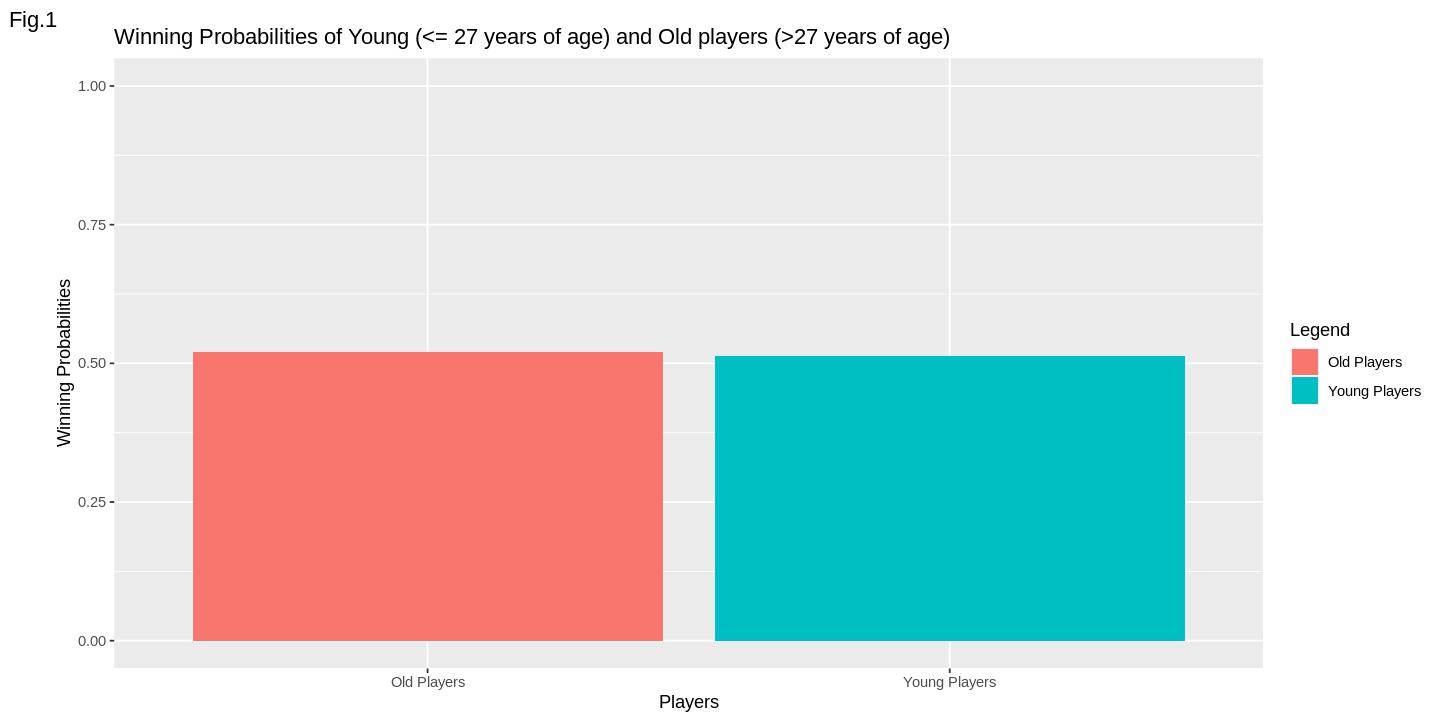

In [23]:
# Do younger players win more than older players? From the mean, we say that players who are 27 or younger are young players,
# and players with age 27 and greater are old players

threshold <- pull(means_df, age)

young <- filter(tennis_train, age <= threshold, match_result == 'win')
old <- filter(tennis_train, age > threshold, match_result == 'win')

young_win_prob <- nrow(young)/nrow(filter(tennis_train, age <= threshold))
old_win_prob <- nrow(old)/nrow(filter(tennis_train, age > threshold))

young_win_prob
old_win_prob

ggplot(tibble(probs=c(young_win_prob, old_win_prob), lab=c('Young Players', 'Old Players')), aes(x=lab,y=probs, fill=lab)) +
geom_bar(stat='identity') + 
ylim(c(0,1)) + 
labs(x='Players', y='Winning Probabilities', tag='Fig.1', title='Winning Probabilities of Young (<= 27 years of age) and Old players (>27 years of age)', fill='Legend')

[1] 0.5062661

[1] 0.52541

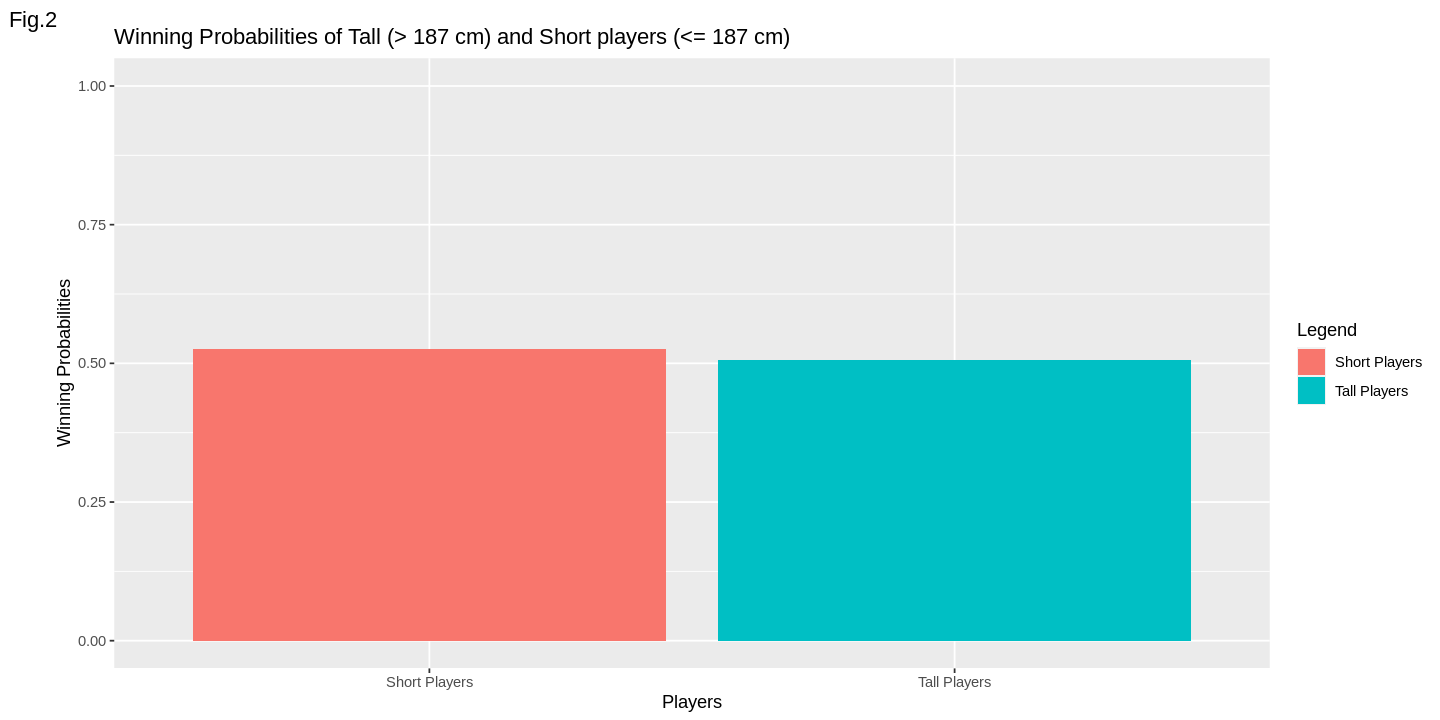

In [26]:
# Do taller players have a higher winrate than shorter players? We set the threshold to me the mean height of players

threshold <- pull(means_df, height)

tall <- filter(tennis_train, height <= threshold, match_result == 'win')
short <- filter(tennis_train, height > threshold, match_result == 'win')

tall_win_prob <- nrow(tall)/nrow(filter(tennis_train, height <= threshold))
short_win_prob <- nrow(short)/nrow(filter(tennis_train, height > threshold))

tall_win_prob
short_win_prob

ggplot(tibble(probs=c(tall_win_prob, short_win_prob), lab=c('Tall Players', 'Short Players')), aes(x=lab,y=probs, fill=lab)) +
geom_bar(stat='identity') + 
ylim(c(0,1)) + 
labs(x='Players', y='Winning Probabilities', tag='Fig.2', title='Winning Probabilities of Tall (> 187 cm) and Short players (<= 187 cm)', fill='Legend')

From the barplots above, we see that height and age do not play a significant role on winrate, when considered individually. Next, we use the ggpairs function to see how the predictors in our training set relate to one another. We also use the correlation function to give us a clearer view of the predictor correlations. 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better valu

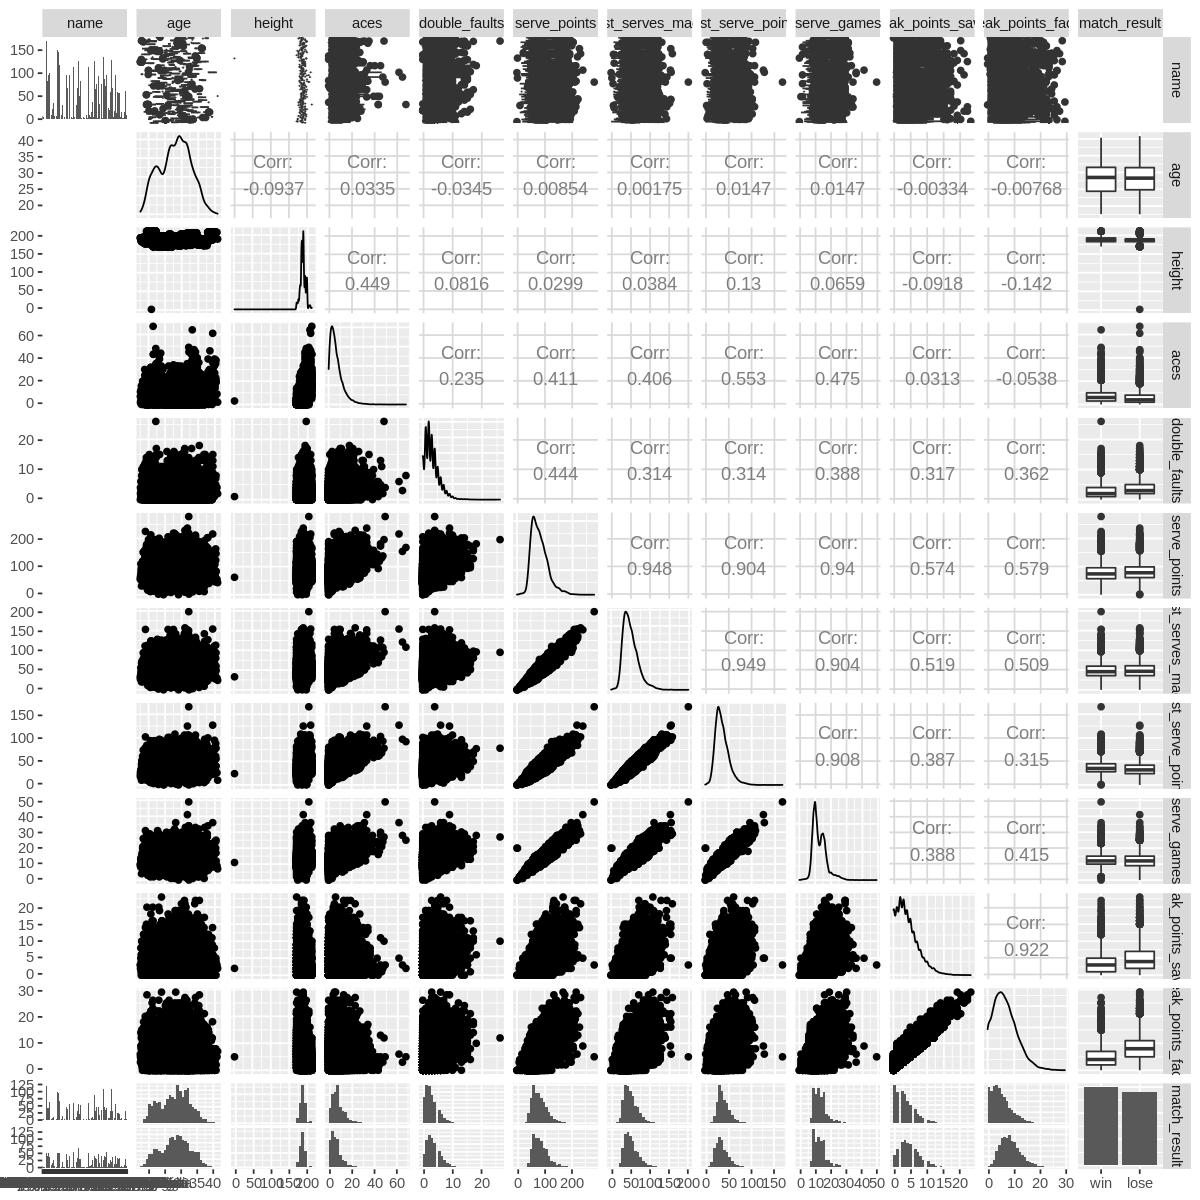

In [111]:
options(repr.plot.height = 10, repr.plot.width = 10)
tennis_eda <- ggpairs(tennis_train, cardinality_threshold=500)
tennis_eda

In [9]:
# view correlations of data

options(repr.matrix.max.rows = 10)
cor(drop_na(tennis_train[,2:11]))

,age,height,aces,double_faults,serve_points,first_serves_made,first_serve_points,serve_games,break_points_saved,break_points_faced
age,1.000000000,-0.09371517,0.03353357,-0.03452500,0.008542338,0.001754764,0.01469182,0.0147455,-0.003335014,-0.00767871
height,-0.093715167,1.00000000,0.44879217,0.08163948,0.029884127,0.038412445,0.12977259,0.0658637,-0.091792034,-0.14156424
aces,0.033533573,0.44879217,1.00000000,0.23504411,0.411097143,0.405948910,0.55328758,0.4752550,0.031305099,-0.05377849
double_faults,-0.034524999,0.08163948,0.23504411,1.00000000,0.443766775,0.313896458,0.31375748,0.3875643,0.317016458,0.36245741
serve_points,0.008542338,0.02988413,0.41109714,0.44376677,1.000000000,0.948436706,0.90414417,0.9404065,0.574224025,0.57851437
first_serves_made,0.001754764,0.03841244,0.40594891,0.31389646,0.948436706,1.000000000,0.94869997,0.9043182,0.519098007,0.50875503
first_serve_points,0.014691824,0.12977259,0.55328758,0.31375748,0.904144165,0.948699968,1.00000000,0.9082615,0.387431060,0.31515892
serve_games,0.014745504,0.06586370,0.47525499,0.38756433,0.940406458,0.904318181,0.90826150,1.0000000,0.387666202,0.41490036
break_points_saved,-0.003335014,-0.09179203,0.03130510,0.31701646,0.574224025,0.519098007,0.38743106,0.3876662,1.000000000,0.92195188
break_points_faced,-0.007678710,-0.14156424,-0.05377849,0.36245741,0.578514368,0.508755029,0.31515892,0.4149004,0.921951877,1.00000000


From the correlation matrix, we notice that some predictors are highly correlated with one another. We wanted to see how these highly correlated predictors (predictors with a correlation of higher than 0.9) interacted with the match result labels, and we visulize this using scatterplots shown below: 

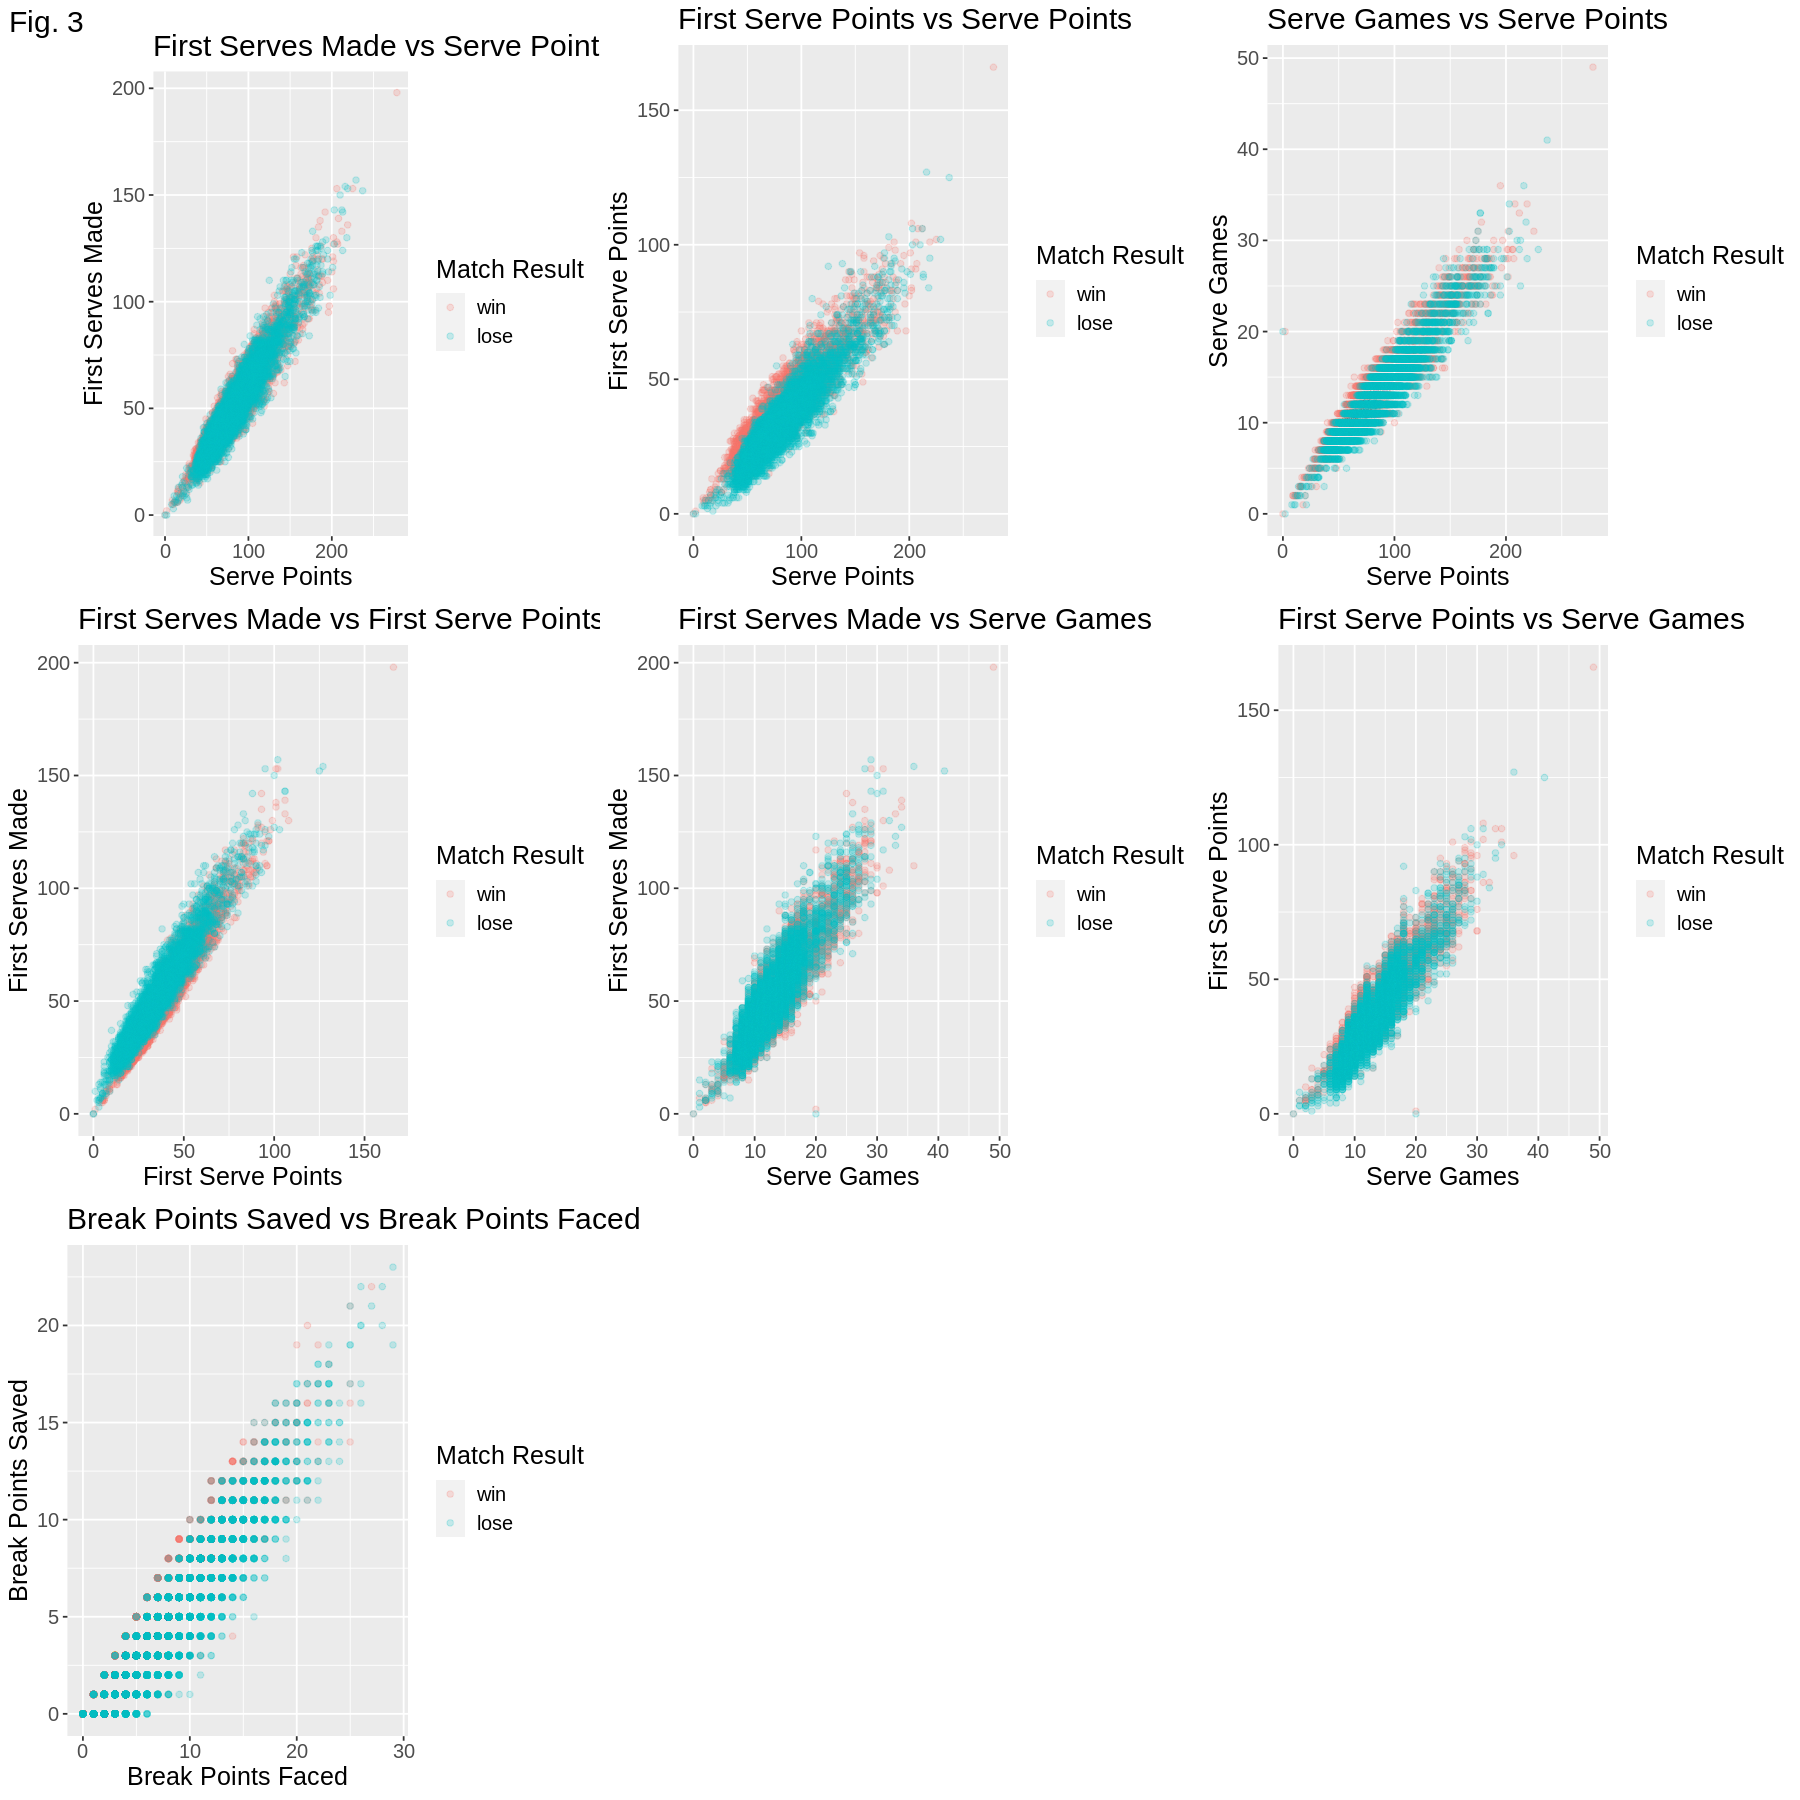

In [27]:
options(repr.plot.height = 15, repr.plot.width = 15)

tennis_train_1 <- ggplot(tennis_train[,2:12], aes(x=serve_points, y=first_serves_made, color=match_result)) +
                    geom_point(alpha=0.2) + 
                    labs(x='Serve Points', y='First Serves Made', title='First Serves Made vs Serve Points', color='Match Result', tag='Fig. 3') + 
                    theme(text = element_text(size = 15))

tennis_train_2 <- ggplot(tennis_train[,2:12], aes(x=serve_points, y=first_serve_points, color=match_result)) +
                    geom_point(alpha=0.2) + 
                    labs(x='Serve Points', y='First Serve Points', title='First Serve Points vs Serve Points', color='Match Result') + 
                    theme(text = element_text(size = 15))

tennis_train_3 <- ggplot(tennis_train[,2:12], aes(x=serve_points, y=serve_games, color=match_result)) +
                    geom_point(alpha=0.2) + 
                    labs(x='Serve Points', y='Serve Games', title='Serve Games vs Serve Points', color='Match Result') + 
                    theme(text = element_text(size = 15))

tennis_train_4 <- ggplot(tennis_train[,2:12], aes(x=first_serve_points, y=first_serves_made, color=match_result)) +
                    geom_point(alpha=0.2) + 
                    labs(x='First Serve Points', y='First Serves Made', title='First Serves Made vs First Serve Points', color='Match Result') + 
                    theme(text = element_text(size = 15))

tennis_train_5 <- ggplot(tennis_train[,2:12], aes(x=serve_games, y=first_serves_made, color=match_result)) +
                    geom_point(alpha=0.2) + 
                    labs(x='Serve Games', y='First Serves Made', title='First Serves Made vs Serve Games', color='Match Result') + 
                    theme(text = element_text(size = 15))

tennis_train_6 <- ggplot(tennis_train[,2:12], aes(x=serve_games, y=first_serve_points, color=match_result)) +
                    geom_point(alpha=0.2) + 
                    labs(x='Serve Games', y='First Serve Points', title='First Serve Points vs Serve Games', color='Match Result') + 
                    theme(text = element_text(size = 15))

tennis_train_7 <- ggplot(tennis_train[,2:12], aes(x=break_points_faced, y=break_points_saved, color=match_result)) +
                    geom_point(alpha=0.2) + 
                    labs(x='Break Points Faced', y='Break Points Saved', title='Break Points Saved vs Break Points Faced', color='Match Result') + 
                    theme(text = element_text(size = 15))

plot_grid(tennis_train_1,tennis_train_2,tennis_train_3,tennis_train_4,tennis_train_5,tennis_train_6,tennis_train_7)

As we see from the scatterplots above, predictors with high correlation with each other do not seem to split the data by match result well. Many of the win and lose data points are overlayed with one another, with no obvious split in data. We conclude that predictors with high correlation will not act as good predictors for a KNN classifier. 

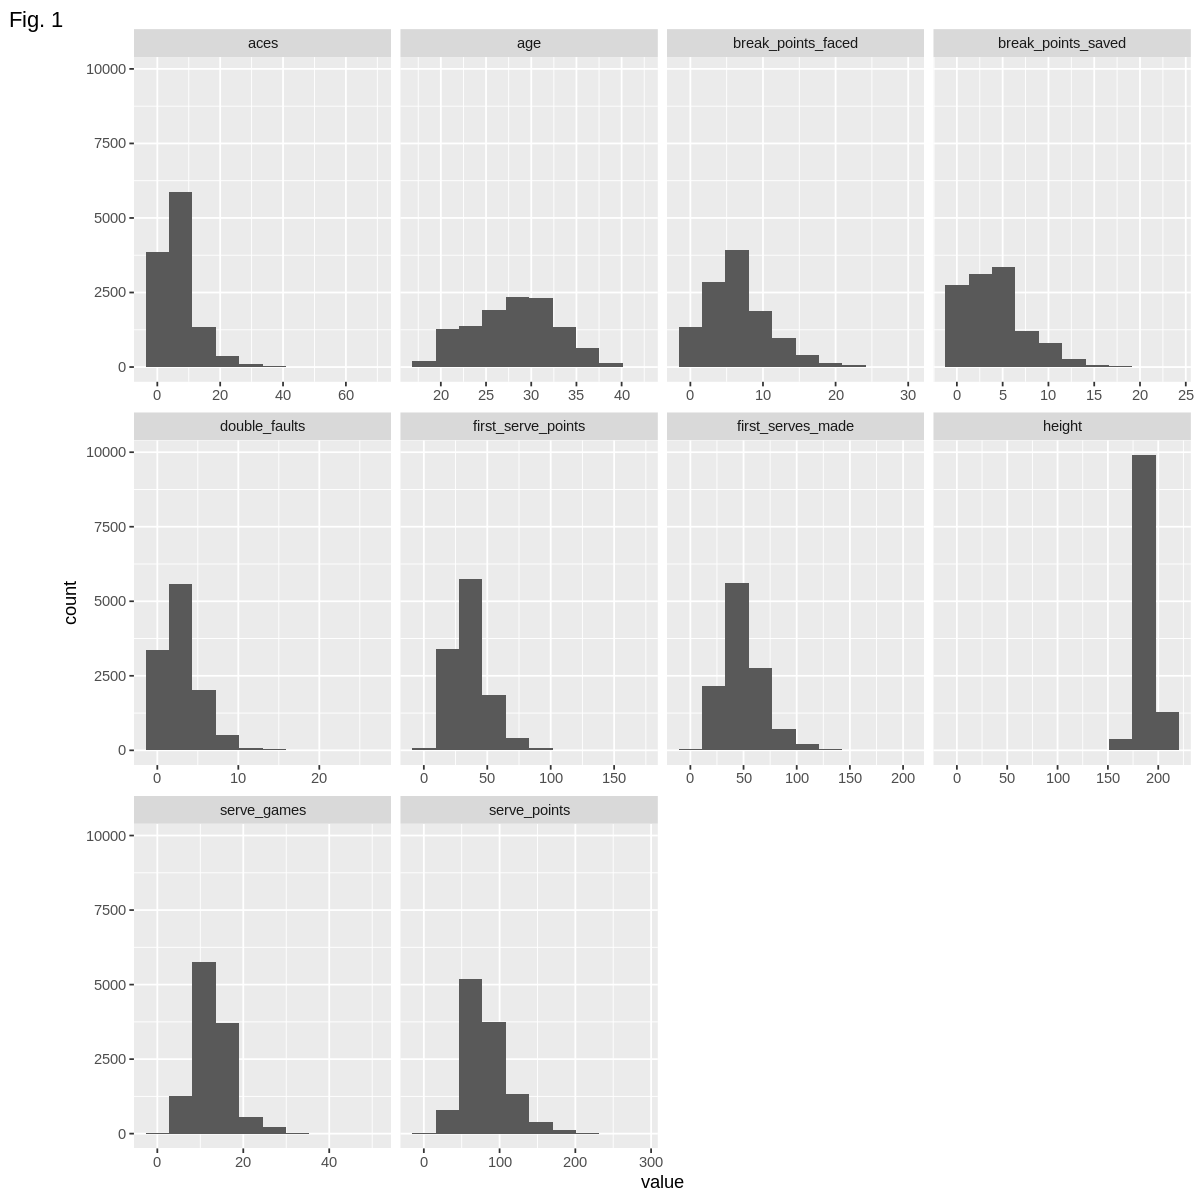

In [112]:
# not sure what to say for this cell, if we can't think of much we'll take it out

ggplot(gather(tennis_train[,2:11]), aes(value)) + 
    geom_histogram(bins = 10) + 
    facet_wrap(~key, scales = 'free_x') + 
    labs(tag="Fig. 1")

# Building the KNN Classifier

## Variable Selection

As we have 10 predictors, we want to see which predictors are the most effective in predicting match results. We use forward selection to see which predictors are the most effective. Starting with one predictor, we find the optimal models for up to three predictors, and see which model has the highest accuracy (we go up to three as peforming forward selection up to 10 predictors would be too time consuming, and difficult to visualize past three predictors). We modify the code given in the textbook to implement forward selection below:

In [38]:
set.seed(99)

# column names
names <- tennis_train[,2:11] %>% colnames()

# create an empty tibble to store the results
accuracies <- tibble(size = integer(), 
                     model_string = character(), 
                     accuracy = numeric())

# create a model specification
knn_spec <- nearest_neighbor(weight_func = 'rectangular', neighbors=tune()) %>%
                set_engine('kknn') %>%
                set_mode('classification')

# create a 5-fold cross-validation object
tennis_vfold <- vfold_cv(tennis_train[,2:12], v = 5, strata = match_result)

# store the total number of predictors
n_total <- 3

# stores selected predictors
selected <- c()

# for every size from 1 to the total number of predictors
for (i in 1:n_total) {
    # for every predictor still not added yet
    accs <- list()
    models <- list()
    for (j in 1:length(names)) {
        # create a model string for this combination of predictors
        preds_new <- c(selected, names[[j]])
        model_string <- paste("match_result", "~", paste(preds_new, collapse="+"))

        # create a recipe from the model string
        tennis_recipe <- recipe(as.formula(model_string), data = tennis_train[,2:12]) %>%
                          step_scale(all_predictors()) %>%
                          step_center(all_predictors())

        # tune the KNN classifier with these predictors, 
        # and collect the accuracy for the best K
        acc <- workflow() %>%
          add_recipe(tennis_recipe) %>%
          add_model(knn_spec) %>%
          tune_grid(resamples = tennis_vfold, grid = tibble(neighbors=seq(1,20))) %>%
          collect_metrics() %>%
          filter(.metric == "accuracy") %>%
          summarize(mx = max(mean))
        acc <- acc$mx %>% unlist()

        # add this result to the dataframe
        accs[[j]] <- acc
        models[[j]] <- model_string
    }
    jstar <- which.max(unlist(accs))
    accuracies <- accuracies %>%
      add_row(size = i, 
              model_string = models[[jstar]], 
              accuracy = accs[[jstar]])
    selected <- c(selected, names[[jstar]])
    names <- names[-jstar]
}

accuracies

size,model_string,accuracy
<int>,<chr>,<dbl>
1,match_result ~ first_serve_points,0.5296505
2,match_result ~ first_serve_points+break_points_faced,0.7105767
3,match_result ~ first_serve_points+break_points_faced+break_points_saved,0.7684099


From the accuracy table, we see that the model with two predictors has a similar accuracy to the model with three predictors. Along with the fact that a model with two predictors is easier to interpret visually, we choose the model with two predictors to continue with our analysis. Using the predictors first_serve_points and break_points_faced, we tune a KNN classifier to select the optimal number of neighbors.

In [31]:
# with the optimal predictors above, tune knn model:
set.seed(99)

# find optimal k for model with 2 variables
# model_string <- accuracies %>% slice(2) %>% select(model_string) %>% pull()

optimal_recipe <- recipe(as.formula(model_string), data = tennis_train[,2:12]) %>%
                    step_scale(all_predictors()) %>%
                    step_scale(all_predictors())

spec_tuning <- nearest_neighbor(weight_func = 'rectangular', neighbors=tune()) %>%
                    set_engine('kknn') %>%
                    set_mode('classification')

tennis_vfold <- vfold_cv(tennis_train[,2:12], v = 5, strata = match_result)

knn_results <- workflow() %>%
                add_recipe(optimal_recipe) %>%
                add_model(spec_tuning) %>%
                tune_grid(resamples=tennis_vfold, grid=tibble(neighbors=seq(1,20))) %>%
                collect_metrics()

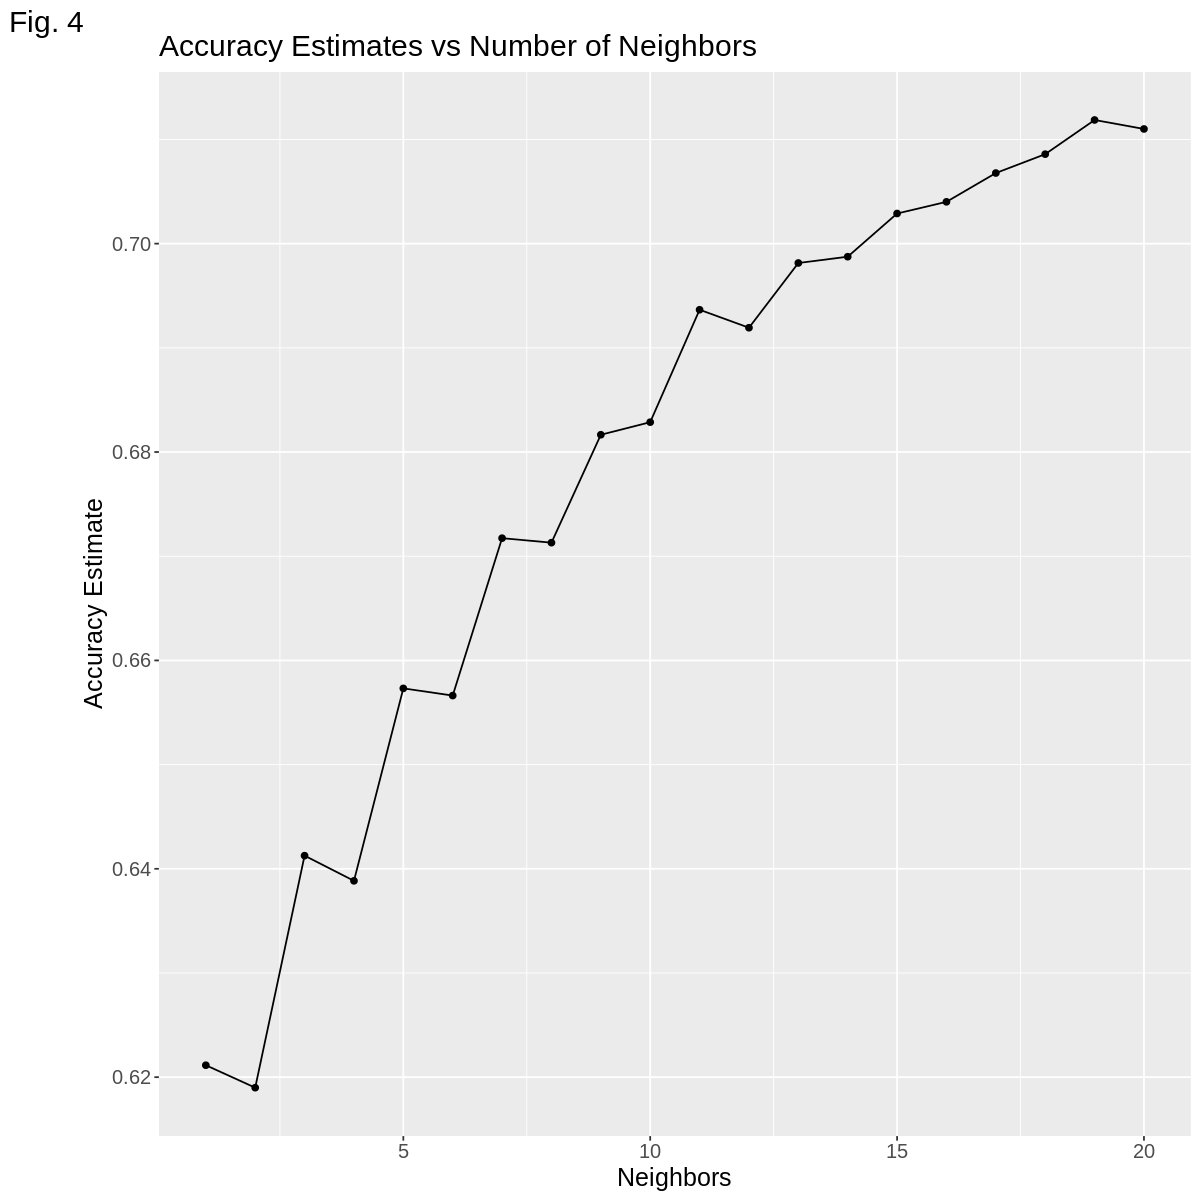

In [34]:
options(repr.plot.height = 10, repr.plot.width = 10)

knn_results_graph <- knn_results %>%
                        filter(.metric=='accuracy') %>%
                        ggplot(aes(x=neighbors, y=mean)) + 
                        geom_point() + 
                        geom_line() + 
                        labs(x='Neighbors', y='Accuracy Estimate', tag='Fig. 4', title='Accuracy Estimates vs Number of Neighbors') + 
                        theme(text = element_text(size = 15))

knn_results_graph

From the accuracy vs neighbors graph above, we see that at K = 19, we get optimal accuracy and increasing or decreasing the number of neighbors by one does not decrease the accuracy significantly. Unfortunately, the downside of choosing our number of neighbors to be 19 is that the cost of training the model is relatively high, since our dataset is fairly large (roughly 11000 rows of data in the training set, from combining the number of wins and loses data points shown in the data preprocessing steps). However, we do not think that our data set is large enough that choosing the number of neighbors to be 19 would slow down the training process too much, so we set the optimal number of neighbors to be 19. Afterwards, we train our classifier using the two predictors chosen from forward selection along with our optimal K value, and use the model to predict the data found in the test set. 

In [7]:
optimal_k = 19

In [8]:
# train model with optimal k
knn_recipe <- recipe(as.formula(model_string), data = tennis_train[,2:12]) %>%
                    step_scale(all_predictors()) %>%
                    step_scale(all_predictors())

optimal_spec <- nearest_neighbor(weight_func = 'rectangular', neighbors=optimal_k) %>%
                    set_engine('kknn') %>%
                    set_mode('classification')

knn_fit <- workflow() %>%
            add_recipe(knn_recipe) %>%
            add_model(optimal_spec) %>%
            fit(data=tennis_train[,2:12])

predictions <- knn_fit %>%
                predict(tennis_test) %>%
                bind_cols(tennis_test)

head(predictions)

.pred_class,name,age,height,aces,double_faults,serve_points,first_serves_made,first_serve_points,serve_games,break_points_saved,break_points_faced,match_result
<fct>,<chr>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<fct>
win,Kei Nishikori,29.00479,178,5,2,59,47,37,12,0,1,win
win,Jo-Wilfried Tsonga,33.70568,188,11,1,76,41,33,11,2,3,win
win,Jordan Thompson,24.69815,183,1,2,42,29,23,8,0,1,win
win,Alex De Minaur,19.86858,183,1,2,43,28,25,8,3,4,win
win,Miomir Kecmanovic,19.33470,183,5,2,45,25,22,8,1,1,win
win,Grigor Dimitrov,27.62765,188,9,6,76,43,37,10,6,7,win


To evaluate the model's performance, we look at the accuracy and the confusion matrix:

In [19]:
# evaluate model performance with accuracy
accuracy <- predictions %>%
                metrics(truth=match_result, estimate=.pred_class) %>%
                filter(.metric=='accuracy') %>%
                pull()
accuracy

[1] 0.7073297

In [20]:
# compute confusion matrix 
conf_matrix <- predictions %>%
                conf_mat(truth=match_result, estimate=.pred_class)
conf_matrix

          Truth
Prediction  win lose
      win  1657  793
      lose  337 1074

The accuracy of our model is very similar to the accuracy of the model trained from forward selection. Looking at the confusion matrix, it seems that our model is more prone to commiting Type 1 errors (classifying losing games as wins) over Type 2 errors (classifying winning games as losses). In the context of discovering which predictors most effectively predict whether a tennis player would win a match, we would want our model to be resistant to Type 1 errors, or classifying losing games as winning ones, which means our model is not ideal. We delve deeper into our model's performance by looking at the scatter plot of predicted labels versus a scatter plot of the actual data set: 

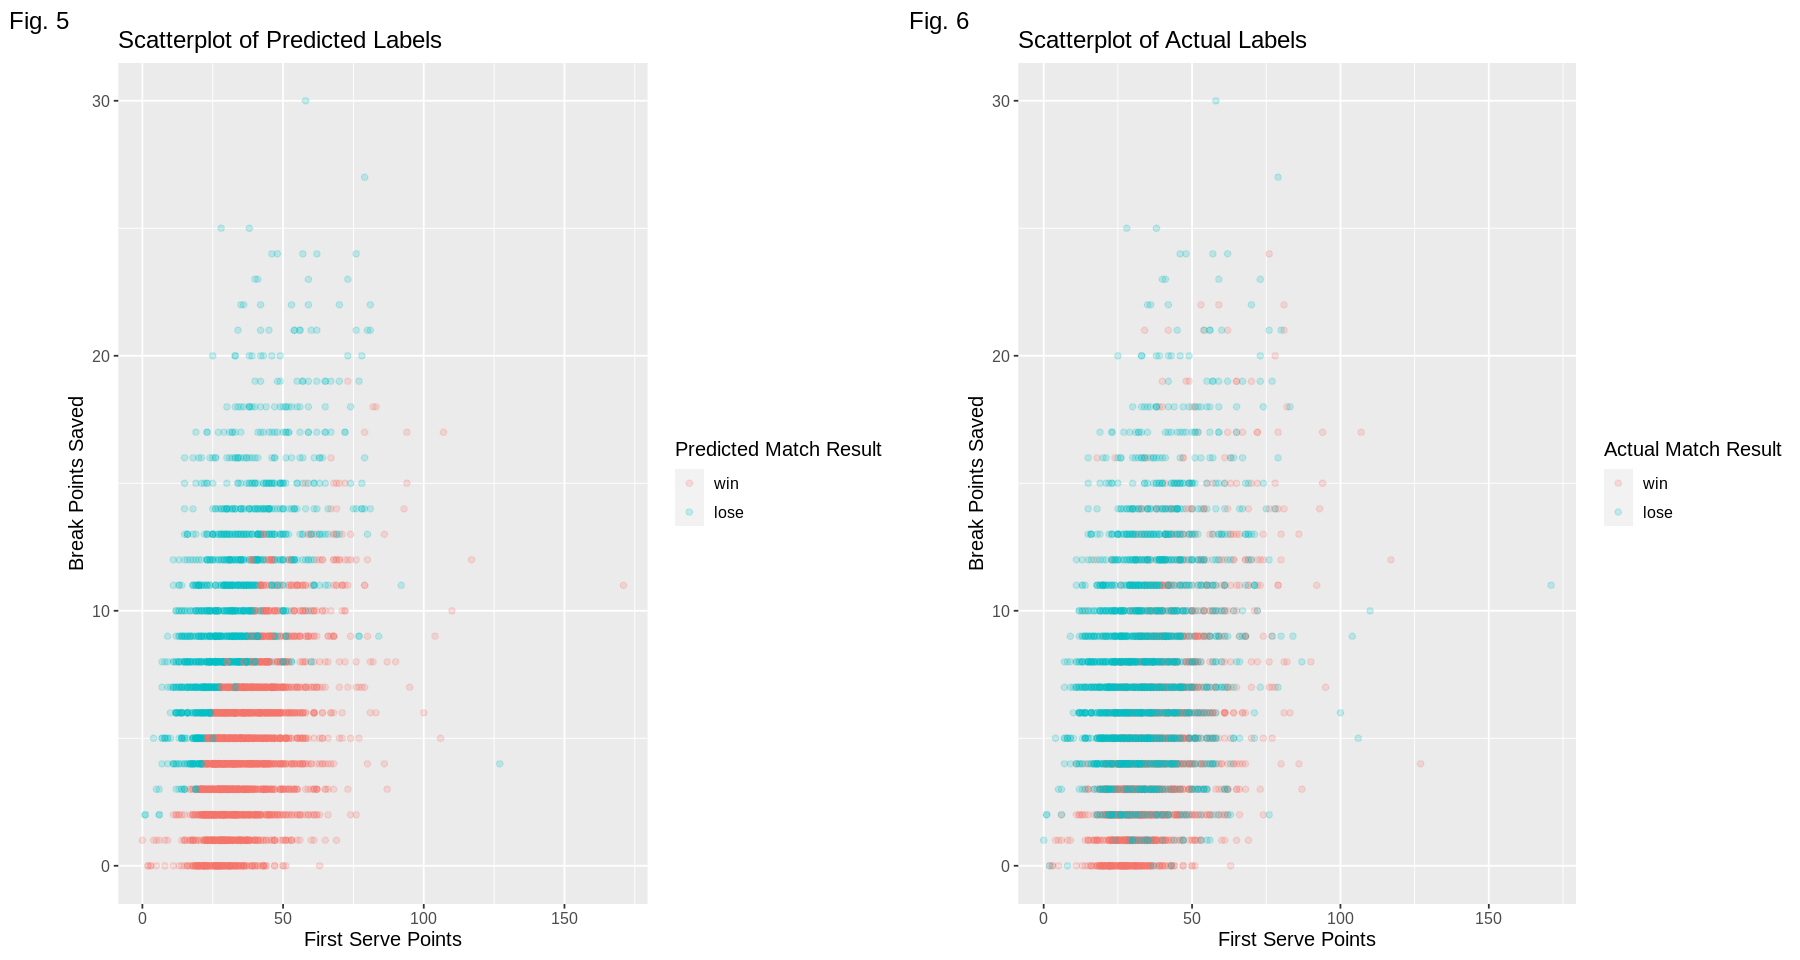

In [40]:
options(repr.plot.height = 8, repr.plot.width = 15)

knn_pred_plot <- ggplot(predictions, aes(x=first_serve_points, y=break_points_faced, color=.pred_class)) + 
                        geom_point(alpha = 0.2) + 
                        labs(x='First Serve Points',
                             y='Break Points Saved', 
                             title='Scatterplot of Predicted Labels',
                             tag='Fig. 5',
                             color='Predicted Match Result') + 
                        theme(text = element_text(size = 12))

knn_actual_plot <- ggplot(predictions, aes(x=first_serve_points, y=break_points_faced, color=match_result)) + 
                        geom_point(alpha = 0.2) + 
                        labs(x='First Serve Points',
                             y='Break Points Saved', 
                             title='Scatterplot of Actual Labels',
                             tag='Fig. 6',
                             color='Actual Match Result') +
                        theme(text = element_text(size = 12))

plot_grid(knn_pred_plot, knn_actual_plot)

From the scatterplots above, we see that the model creates a clear central split between won and lost matches, whereas the actual test data shows that losing match data points take up the center of the data, with winning match data points being scattered at the edges of the graph. From this, we see visually that our model is prone to classifying lost games as winning ones. 

## Discussion

The aim of our project is to test which predictors play the most critical role in the result of a tennis match. Our analysis concludes that the predictors, the first serve points and the breakpoints faced, are the optimal predictors to predict the outcome of a tennis match. Through the analysis of our dataset, we first summarized the statistics for each predictor and used the ggpairs to see how the predictors in the training set relate to each other. From the correlation matrix, we picked seven pairs of predictors with correlation higher than 0.9. The scatterplots concluded that predictors with high correlation would not act as good predictors for a KNN classifier. Then from the forward selection, we chose the model with two predictors and tuned a KNN classifier to select the optimal number of neighbors k = 19. The accuracy of our optimal model is very similar to the accuracy of the model trained from forward selection. However, our model is more prone to committing Type 1 errors (classifying losing games as wins) over Type 2 errors (classifying winning games as losses). 
 
From our expectation, we anticipated to find players with higher positive tennis stats, greater height, and younger age would be more likely to win a game, and we expected that age and height would be the best predictors. But from our analysis, the probability of winning is very close to the probability of losing for the difference of age and height. Moreover, the first serve points and the breakpoints faced were the better predictors. 


## Limitations

The first limitation would be the k value. From the accuracy vs. neighbors graph, we picked our optimal k value to be 19. However, the cost of training the model would be relatively high due to the large dataset we have. Even though our dataset was not large enough to have a more significant impact, choosing k to be 19 would slow down the training process. 
Another limitation of our analysis is that we have to choose two predictors over ten due to extensive computation in forward selection and difficulty in visualization. Including more predictors in our model may increase accuracy.
From the confusion matrix of our final model, our optimal model is more prone to type one error, which means that our prediction classifies more losing games as winning games. Hence, the model is not ideal enough.

## Impacts & Future Questions

Our findings help to discover that the first serve points and the breakpoints faced are the most important factors for winning in professional tennis matches. Based on the importance of the first serve points and the breakpoints faced, coaches could help build an efficient training plan for athletes. For example, a coach can prioritize perfecting a player's first serve over other techniques, considering the importance of first-serve points in the game's result. Besides, the players should be mentally prepared well when facing the breakpoints because that may change the result of the game. Our analysis can lead to discovering other predictors that could better predict the outcome of a match.


## References

Amin Ahmadi, David Rowlands & Daniel Arthur James (2009) Towards a wearable device for skill assessment and skill acquisition of a tennis player during the first serve, Sports Technology, 2(3-4), 129-136, DOI: https://doi.org/10.1080/19346182.2009.9648510

Klaassen, Franc J. G. M., and Jan R. Magnus (2003). “Forecasting the Winner of a Tennis Match.” European Journal of Operational Research, 148(2),257-267, DOI:https://doi.org/10.1016/S0377-2217(02)00682-3.

Ultimate Tennis Statistics. (n.d.). Retrieved December 9, 2021, from https://www.ultimatetennisstatistics.com/.
